In [ ]:
import numpy as np

import jax.numpy as jnp
from jax import lax
from jax import config
from jax import jit, grad, jacobian, hessian
config.update("jax_enable_x64", True)

import sys

from mpl_toolkits.mplot3d import Axes3D, art3d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Circle

# Do this only if you want to interact with 3D plots
# %matplotlib notebook

In [ ]:
# Given a function fun: R^2 -> R, create points to plot
def get_plot_points(fun, x_bounds=(-5,5), y_bounds=(-5,5)):
  X = np.linspace(*x_bounds, 20)
  Y = np.linspace(*y_bounds, 20)
  X, Y = np.meshgrid(X, Y)
  XY = np.stack([X, Y]).transpose(1, 2, 0)
  Z = []
  for row in XY:
    for pair in row:
      Z.append(fun(pair))
  Z = np.array(Z)
  Z = Z.reshape((len(X), -1))
  return X, Y, Z

# Make a 3D plot of the points
def make_3d_plot(X, Y, Z, title=None):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
  if title:
    ax.set_title(title)
  plt.show()

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


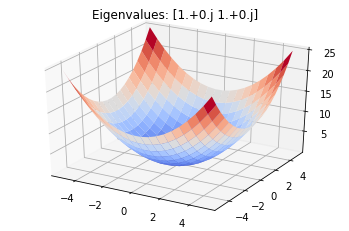

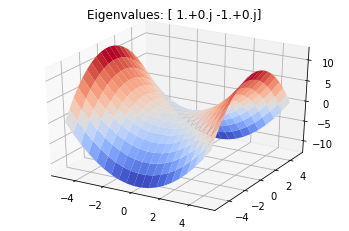

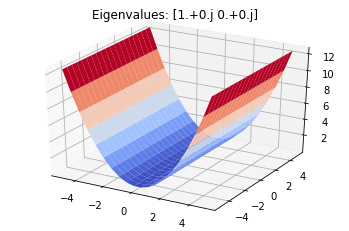

In [ ]:
# Plot some example quadric surfaces, along with their eigenvalues

# Point for evaluating the eigenvalues
pt = jnp.array([0., 0.])

# Convex
f_convex = lambda x : 0.5 * (x[0]**2 + x[1]**2)
make_3d_plot(*get_plot_points(f_convex),
             title="Eigenvalues: {}".format(jnp.linalg.eigvals(hessian(f_convex)(pt))))

# Saddle
f_saddle = lambda x : 0.5 * (x[0]**2 - x[1]**2)
make_3d_plot(*get_plot_points(f_saddle),
             title="Eigenvalues: {}".format(jnp.linalg.eigvals(hessian(f_saddle)(pt))))

# Cone
f_cone = lambda x : 0.5 * x[0]**2 
make_3d_plot(*get_plot_points(f_cone),
             title="Eigenvalues: {}".format(jnp.linalg.eigvals(hessian(f_cone)(pt))))

In [ ]:
# Given a 2D function and a point, return its second-order Taylor expansion at that point
def get_quad_approx(f, x_k):
  grad_f = jit(grad(f))
  hessian_f = jit(hessian(f))
  def f_approx(x):
    return f(x_k) + grad_f(x_k) @ (x - x_k) + 1/2 * (x - x_k).T @ hessian_f(x_k) @ (x - x_k)
  return f_approx

# Like above, but modify the Hessian so that it's positive definite
def get_pos_def_quad_approx(f, x_k):
  grad_f = jit(grad(f))
  hessian_f = jit(hessian(f))
  def f_approx(x):
    hessian_x_k = hessian_f(x_k)
    min_eigval = jnp.min(jnp.real(jnp.linalg.eigvals(hessian_x_k)))
    should_mod = min_eigval < 0
    hessian_x_k = lax.cond(should_mod,
                           hessian_x_k, lambda X : X + jnp.eye(len(X)) * -min_eigval * 1.1,
                           hessian_x_k, lambda X : X)
    return f(x_k) + grad_f(x_k) @ (x - x_k) + 1/2 * (x - x_k).T @ hessian_x_k @ (x - x_k)
  return f_approx

In [ ]:
# Plot two functions and two points, in 2D
def plot_step_3d(f, f_approx, x_start, x_end, x_bounds=(-10, 10), y_bounds=(-10, 10)):

  # Initialize the figure
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  # Plot the nonlinear function surface
  pts = get_plot_points(f, x_bounds, y_bounds)
  surf = ax.plot_surface(*pts, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.8)

  # Plot the starting point
  p = Circle(x_start, 0.1, ec='k', fc="k")
  ax.add_patch(p)
  art3d.pathpatch_2d_to_3d(p, z=f(pt), zdir="z")

  # Plot the quadratic approximation at the point
  pts2 = get_plot_points(f_approx, x_bounds, y_bounds)
  surf = ax.plot_surface(*pts2, linewidth=0, antialiased=True, alpha=0.6)

  ax.set_zlim(-1.5, 1.5)

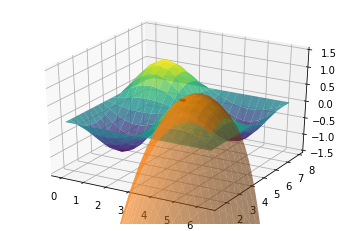

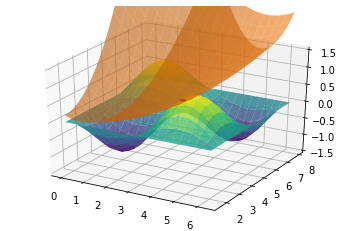

In [ ]:
# Make an example surface and point, and plot its quadratic and pos def quadratic approximations

# Example surface
def sin_prod(x):
  return jnp.sin(x[0]) * jnp.cos(x[1])

# Example point
pt = jnp.array([4., 3.5])

# Approximations
approx = get_quad_approx(f=sin_prod, x_k=pt)
pos_def_approx = get_pos_def_quad_approx(f=sin_prod, x_k=pt)

# Bounds for plots
bounds = ((0, 2*jnp.pi), (1/2*jnp.pi, 5/2*jnp.pi))

# Plots
plot_step_3d(sin_prod, approx, pt, pt, *bounds)
plot_step_3d(sin_prod, pos_def_approx, pt, pt, *bounds)

In [ ]:
# A 2D version of plot_step_3d
def plot_step_2d(f, f_approx, x_start, x_end, x_bounds=(-10, 10), y_bounds=(-10, 10)):

  # Initialize the figure
  fig, ax = plt.subplots()
  
  # Plot the points
  ax.plot(*x_start, 'o')
  ax.plot(*x_end, 'x', c="b")

  # Plot the surface
  pts = get_plot_points(f, x_bounds, y_bounds)
  im = ax.imshow(pts[2], interpolation='bilinear', origin='lower',
                cmap=cm.gray, extent=(*x_bounds, *y_bounds), alpha=0.5)
  CBI = fig.colorbar(im, orientation='vertical', shrink=0.8, alpha=0.5)

  # Plot the quadratic approximation at the point
  pts2 = get_plot_points(f_approx, x_bounds, y_bounds)
  surf = ax.contour(*pts2, alpha=1, linewidths=4, cmap=cm.cool)
  CB = fig.colorbar(surf, shrink=0.8, extend='both')

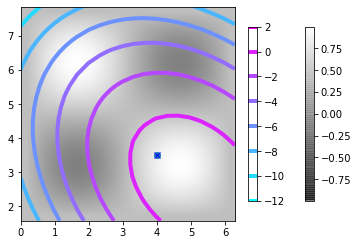

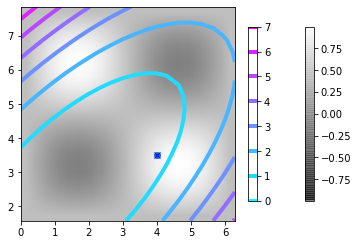

In [ ]:
# Same example as before, now with 2D plots
plot_step_2d(sin_prod, approx, pt, pt, *bounds)
plot_step_2d(sin_prod, pos_def_approx, pt, pt, *bounds)

In [ ]:
# Newton's method for 2D functions
def newton(saddle_func, init_x, mod=False,
                              rtol=1e-10, atol=1e-10, max_iter=5000,
                              batched_iter_size=1,
                              x_bounds=(-10, 10), y_bounds=(-10, 10),
                              plotting='2D'):
  
  # Get the gradient and hessian functions
  jac_f = jit(grad(saddle_func))
  hes_f = jit(jacobian(jac_f))

  def convergence_test(x_new, x_old):
    del x_old
    return jnp.all(jnp.abs(jac_f(x_new)) < 1e-8)

  def _newton_step(x):
    return x + jnp.linalg.solve(hes_f(x), -jac_f(x))
  
  def _modded_newton_step(x):
    H = hes_f(x)
    min_eigval = jnp.min(jnp.real(jnp.linalg.eigvals(H)))
    should_mod = min_eigval < 0
    modded_H = lax.cond(should_mod,
                        H, lambda X : X + jnp.eye(len(X)) * -min_eigval * 1.1,
                        H, lambda X : X)
    return x + jnp.linalg.solve(modded_H, -jac_f(x))
  
  x_old = jnp.ones_like(init_x) * -1
  x_new = init_x

  for i in range(max_iter):
    
    # Check convergence
    if convergence_test(x_old, x_new):
      break

    # Take Newton Step
    x_old = x_new
    
    if mod:
      x_new = _modded_newton_step(x_new)
    else:
      x_new = _newton_step(x_new)
    
    # Plot, if desired
    if plotting:
      
      # Get the quadratic approximation
      if mod:
        f_approx = get_pos_def_quad_approx(f=saddle_func, x_k=x_old)
      else:
        f_approx = get_quad_approx(f=saddle_func, x_k=x_old)
      
      # Make the plot
      if plotting == '2D':
        plot_step_2d(saddle_func, f_approx, x_old, x_new, x_bounds, y_bounds)
      else:
        plot_step_3d(saddle_func, f_approx, x_old, x_new, x_bounds, y_bounds)
    
  return x_new

Newton's Method


DeviceArray([4.71238898, 3.14159265], dtype=float64)

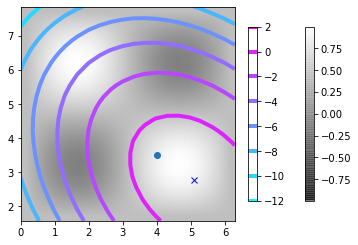

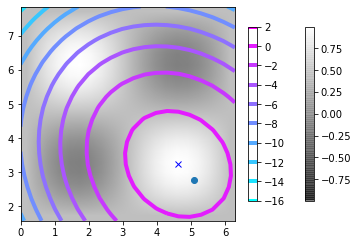

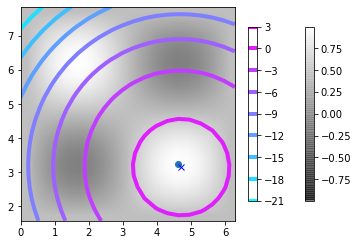

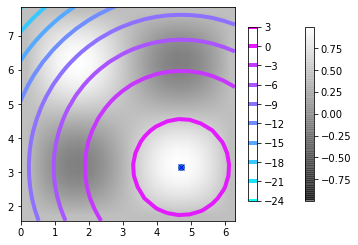

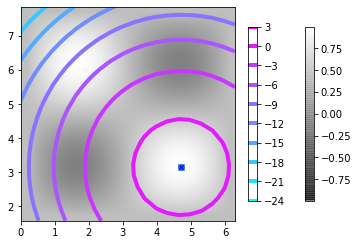

In [ ]:
print("Newton's Method")
newton(sin_prod, pt, rtol=0, atol=1e-4,
       x_bounds = (0, 2*jnp.pi),
       y_bounds = (1/2*jnp.pi, 5/2*jnp.pi))

Newton's Method, with modified Hessian


DeviceArray([1.57079633, 3.14159265], dtype=float64)

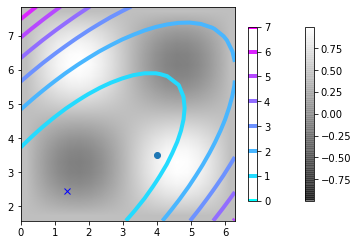

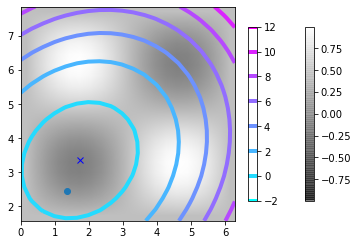

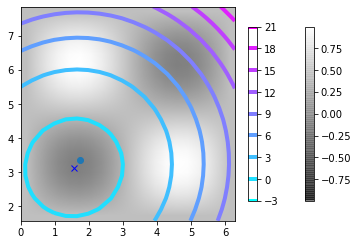

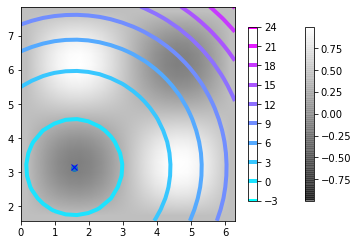

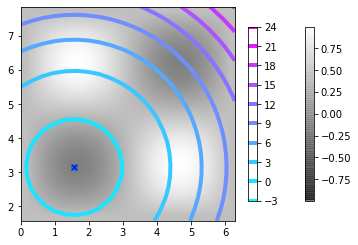

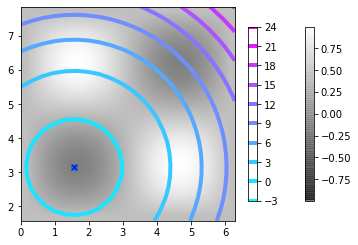

In [ ]:
print("Newton's Method, with modified Hessian")
newton(sin_prod, pt, mod=True, rtol=0, atol=1e-4,
       x_bounds = (0, 2*jnp.pi),
       y_bounds = (1/2*jnp.pi, 5/2*jnp.pi))

### Test Newton's method on a couple of problems

In [ ]:
def convex_test(x):
  return 0.01 * x @ x

Newton's Method


DeviceArray([0., 0.], dtype=float64)

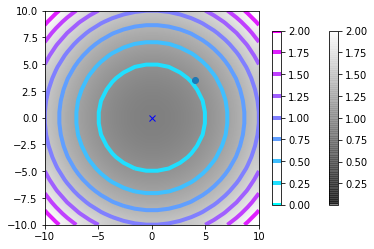

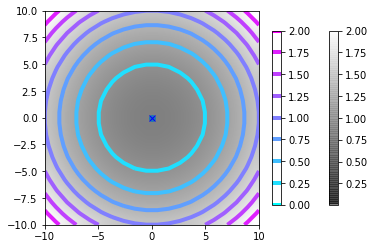

In [ ]:
print("Newton's Method")
newton(convex_test, pt, rtol=0, atol=1e-5)

Newton's Method with Hessian modification


DeviceArray([0., 0.], dtype=float64)

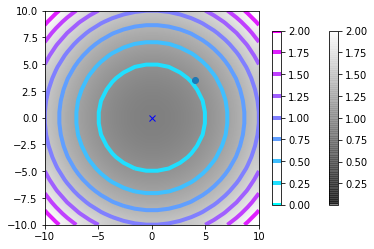

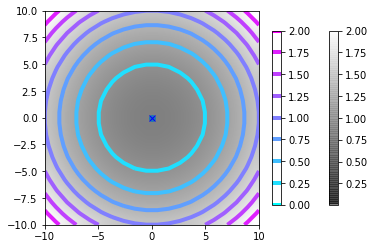

In [ ]:
print("Newton's Method with Hessian modification")
newton(convex_test, pt, mod=True, rtol=0, atol=1e-5)

DeviceArray([0., 0.], dtype=float64)

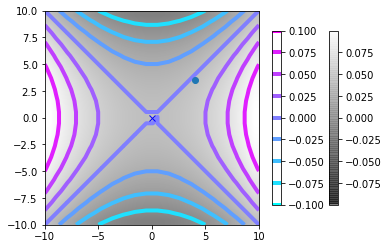

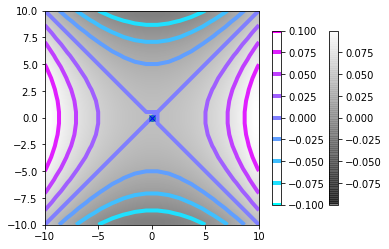

In [ ]:
def saddle_point_test(x):
  return 0.001 * (x[0]*x[0] - x[1]*x[1])

newton(saddle_point_test, pt, rtol=0, atol=1e-5)

(DeviceArray([ 2.0952381, 38.5      ], dtype=float64),)

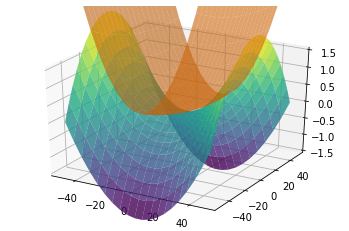

In [ ]:
# This fails because the pos def approximation 'slides down
# the side of the saddle, diverging in x (while converging in y)
newton(saddle_point_test, pt, mod=True, max_iter=1, plotting='3D', rtol=0, atol=1e-5, x_bounds=(-50, 50), y_bounds=(-50, 50)),